Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6175 - loss: 0.6442 - val_accuracy: 0.8625 - val_loss: 0.5716
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8581 - loss: 0.5374 - val_accuracy: 0.9000 - val_loss: 0.4855
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8499 - loss: 0.4681 - val_accuracy: 0.9125 - val_loss: 0.4107
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8445 - loss: 0.4239 - val_accuracy: 0.9125 - val_loss: 0.3517
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8333 - loss: 0.3934 - val_accuracy: 0.9250 - val_loss: 0.3079
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8642 - loss: 0.3407 - val_accuracy: 0.9375 - val_loss: 0.2700
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - loss: 0.3034 - val_accuracy: 0.9375 - val_loss: 0.2407
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9222 - loss: 0.2455 - val_accuracy: 0.9500 - val_loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9071 - loss: 0.2428  
Test Loss: 0.2181
Test Accuracy: 0.9109
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 800x600 with 0 Axes>

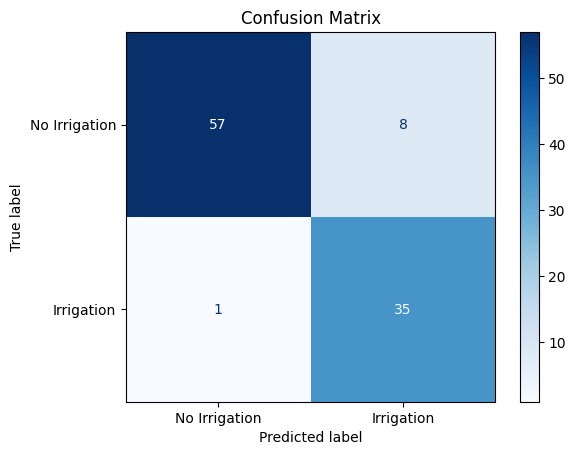

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        65
           1       0.81      0.97      0.89        36

    accuracy                           0.91       101
   macro avg       0.90      0.92      0.91       101
weighted avg       0.92      0.91      0.91       101



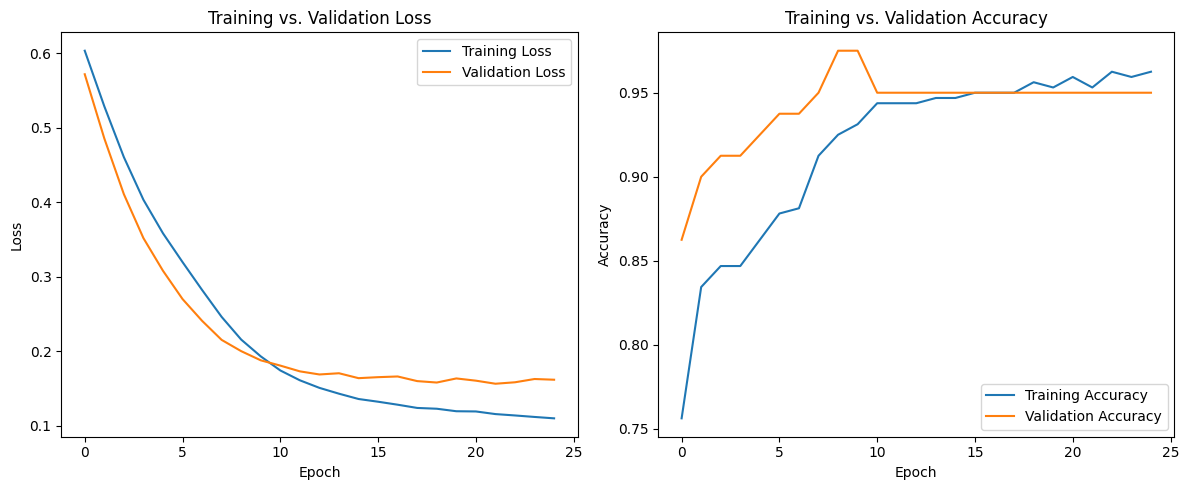

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

data = pd.read_csv('/content/drive/MyDrive/datasets - datasets.csv')

X = data.drop(columns=['Irrigation'])
y = data['Irrigation']

label_encoder = LabelEncoder()
X['CropType'] = label_encoder.fit_transform(X['CropType'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[['SoilMoisture', 'temperature', 'Humidity']] = scaler.fit_transform(X_train[['SoilMoisture', 'temperature', 'Humidity']])
X_test[['SoilMoisture', 'temperature', 'Humidity']] = scaler.transform(X_test[['SoilMoisture', 'temperature', 'Humidity']])

input_crop_type = Input(shape=(1,), name='CropType')
input_numerical = Input(shape=(3,), name='Numerical')

embedding_size = 5
embedding = Embedding(input_dim=len(label_encoder.classes_), output_dim=embedding_size)(input_crop_type)
embedding = Flatten()(embedding)

concatenated = Concatenate()([embedding, input_numerical])

x = Dense(16, activation='relu')(concatenated)
x = Dense(8, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_crop_type, input_numerical], outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_train['CropType'], X_train[['SoilMoisture', 'temperature', 'Humidity']]],
    y_train,
    epochs=25,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stopping]
)

model.save('irrigation_model.h5')

test_loss, test_accuracy = model.evaluate(
    [X_test['CropType'], X_test[['SoilMoisture', 'temperature', 'Humidity']]],
    y_test
)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

y_pred = model.predict([X_test['CropType'], X_test[['SoilMoisture', 'temperature', 'Humidity']]])
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Irrigation', 'Irrigation'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_binary))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
